# Data Preparation

## 1 Setup

In [1]:
#import idstools
from scipy import stats
import time
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
%matplotlib inline

## 2 Import der Daten

Um den Testdatensatz vorzubereiten, hier einfach `test` statt `train` einsetzen.

In [31]:
file_to_prepare = "train"

In [32]:
data = pd.read_csv(f"../data/BikeRentalDaily_{file_to_prepare}.csv", sep=";", index_col=0)

## 3 Minimal Preprocessing

Während unserer ersten Analysen in Task 1 ist uns aufgefallen, dass die Variablen `season` und `hum` fehlende Werte aufweisen. Als Default-Methode und im Sinne von Minimal Preprocessing sollen die Zeilen mit fehlenden Werten entfernt werden.
Optionale Methoden zum Umgang mit fehlenden Werten werden im weiteren Verlauf addressiert.

In [33]:
data = data.dropna()

## 4 Baseline Linear Regression Model

Die Summe von `casual` und `registered` ergibt `cnt`, daher entfernen wir diese Spalten aus dem Datensatz. Zudem wird die Spalte `dteday` sowie das y_label von der Features-Liste entfernt.

temp entfernen

In [34]:
def baseline_linreg(data):
    data = data.dropna()
    y_label = 'cnt'
    features = data.drop(columns=[y_label, 'dteday', 'casual', 'registered', 'temp']).columns
    X = data[features]
    y = data[y_label]
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_validation)
    r2 = r2_score(y_validation, y_pred).round(2)
    mae = mean_absolute_error(y_validation, y_pred).round(2)

    print(f'R2 Score: {r2}')
    print(f'Mean Absolute Error: {mae}')
    print("\nFeature Coefficients:")
    for coef, feature in zip(reg.coef_, X.columns):
        print(feature, abs(round(coef, 2)))
    return reg

In [35]:
baseline_linreg(data)

R2 Score: 0.55
Mean Absolute Error: 889.23

Feature Coefficients:
season 1599.62
yr 2819.56
mnth 276.8
holiday 35.89
weekday 202.18
workingday 822.75
weathersit 701.92
atemp 3762.68
hum 13.78
windspeed 1026.68
leaflets 2.15
price reduction 28.37


LinearRegression()

## 5 Other Options for Missing Value Handling

Wie wir bereits in Task 1 erarbeitet haben, weisen die Spalten `season` und `hum` fehlende Werte auf. Im ersten Schritt haben wir diese Zeilen entfernt. Nun wollen wir die fehlenden Werte imputieren.

In [36]:
data = pd.read_csv(f"../data/BikeRentalDaily_{file_to_prepare}.csv", sep=";", index_col=0)

<Axes: >

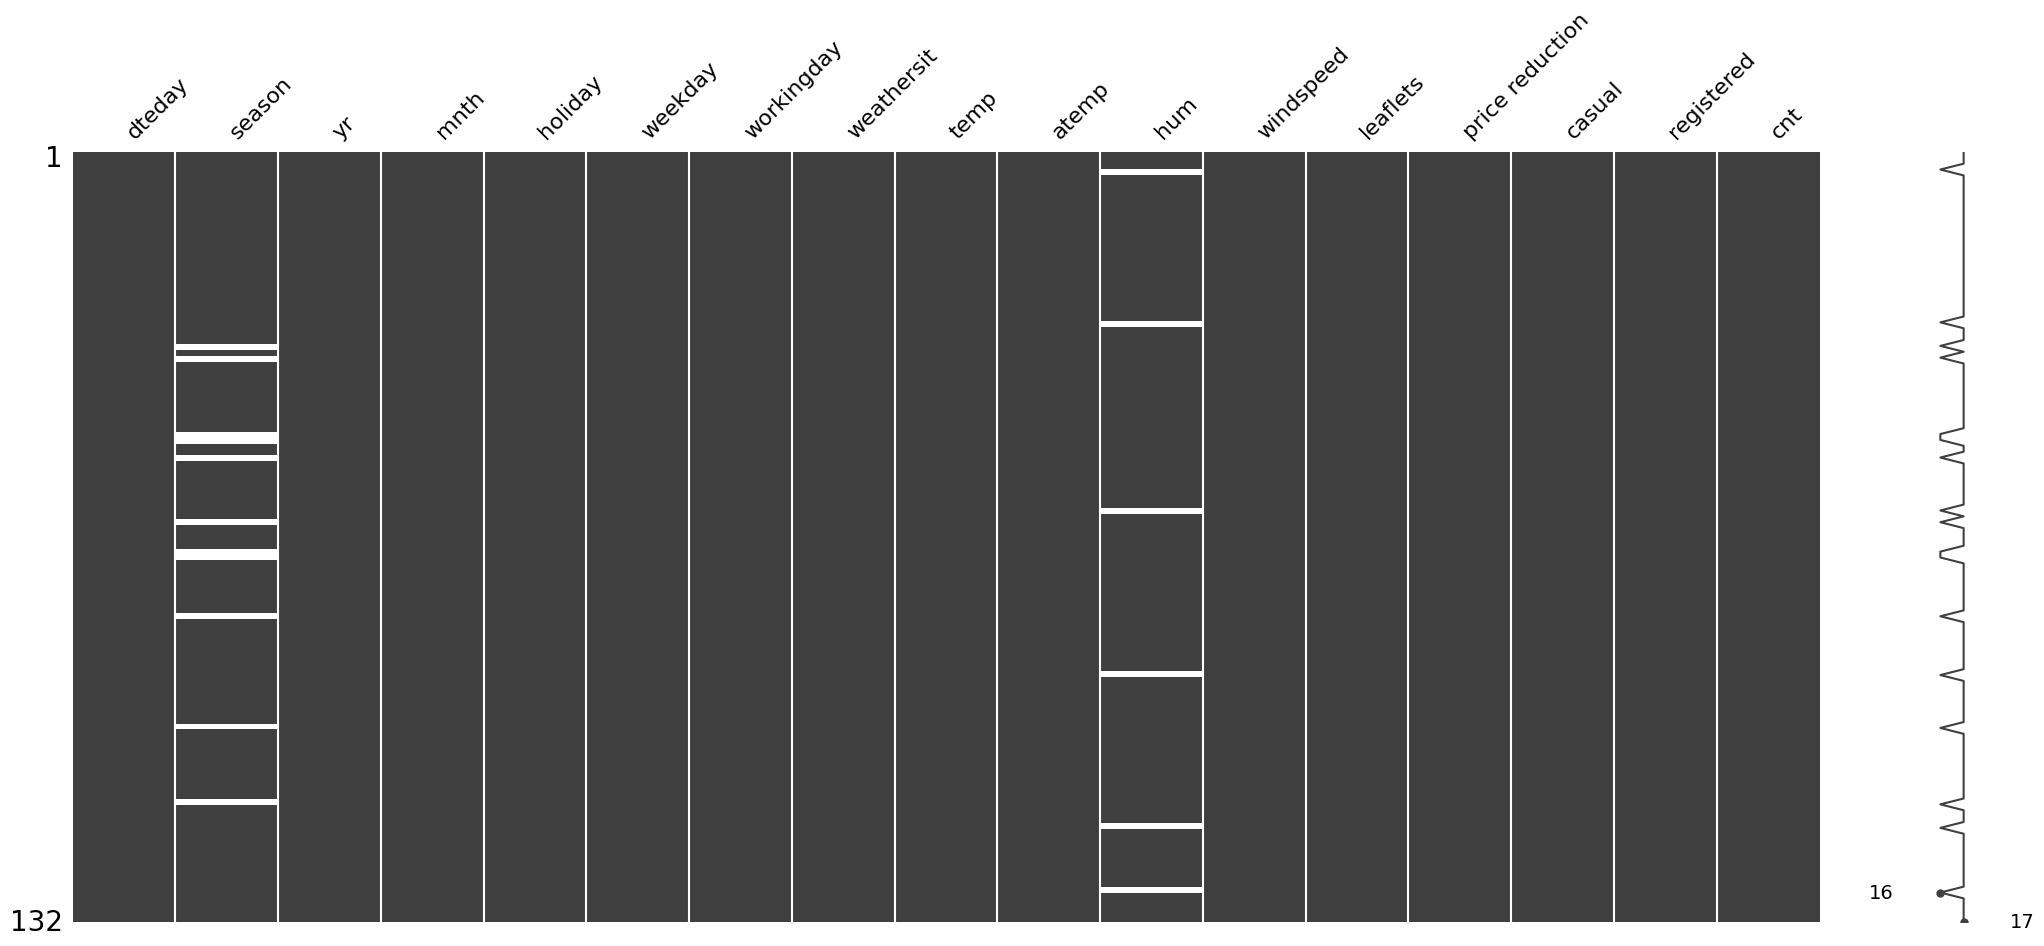

In [37]:
msno.matrix(data)

Die fehlenden Werte in der Spalte `season` werden anhand des vorliegenden Datums in der entsprechenden Zeile aufgefüllt. 

`get_season_by_date` bestimmt die Jahreszeit anhand eines Datums im Format "dd.mm". Sie verwendet das Modul time, um feste Zeitpunkte für den Beginn der Jahreszeiten (Frühling, Sommer, Herbst, Winter) festzulegen und vergleicht dann das eingegebene Datum mit diesen Zeitpunkten. Die Funktion gibt eine Ganzzahl zurück, die die entsprechende Jahreszeit repräsentiert (1 für Frühling, 2 für Sommer, 3 für Herbst, 4 für Winter). Beachte jedoch, dass die Funktion Schwierigkeiten mit dem 29. Februar haben könnte, wenn keine Jahreszahl angegeben ist, da sie die Schaltjahre nicht berücksichtigt.
Es gibt vier fest definierte Zeitpunkte für den Beginn jeder Jahreszeit (Frühling, Sommer, Herbst, Winter). Diese Zeitpunkte sind auf den 20. März, 20. Juni, 20. September und 20. Dezember festgelegt.

In [38]:
# datetime.datetime kann nicht mit 29. Feb umgehen, wenn keine Jahreszahl dabei ist
def get_season_by_date(date: str):
    """Derive season by date"""
    dateformat = "%d.%m"

    # Season beginnings
    spring = time.strptime("20.03", dateformat)
    summer = time.strptime("20.06", dateformat)
    autumn = time.strptime("20.09", dateformat)
    winter = time.strptime("20.12", dateformat)

    date_p = time.strptime(date[:5], dateformat)

    if date_p < spring:
        return 1
    elif spring < date_p < summer:
        return 2
    elif summer < date_p < autumn:
        return 3
    elif autumn < date_p < winter:
        return 4
    else:
        return 1

In [39]:
def season_wrapper(row):
    row["season"] = get_season_by_date(row["dteday"])
    return row
data = data.apply(season_wrapper, axis=1)
data

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,leaflets,price reduction,casual,registered,cnt
instant,,,,,,,,,,,,,,,,,
299,26.10.2011,4,0,10,0,3,1,2,19.3667,0.472846,108.06255,0.148642,605,0,404,3490,3894
458,02.04.2012,2,1,4,0,1,1,1,17.3565,0.427513,75.65220,0.312139,518,0,1208,4728,5936
687,17.11.2012,4,1,11,0,6,0,1,13.0000,0.326383,81.81255,0.179729,766,0,1313,4316,5629
346,12.12.2011,4,0,12,0,-1,1,1,9.5333,0.270196,NaN,0.063450,739,0,143,3167,3310
291,18.10.2011,4,0,10,0,2,1,2,21.3000,0.522721,105.25005,0.110087,463,0,637,4111,4748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,01.03.2012,1,1,3,0,4,1,1,19.4333,0.475371,92.31255,0.226987,777,0,325,4665,4990
547,30.06.2012,3,1,6,0,6,0,1,30.6000,0.687508,90.18750,0.161071,981,0,1455,4232,5687
271,28.09.2011,4,0,9,0,-1,1,2,25.4000,0.575158,127.31250,0.148629,577,0,480,3427,3907


Build a Linear Regression Model

In [40]:
baseline_linreg(data)

R2 Score: 0.09
Mean Absolute Error: 1357.34

Feature Coefficients:
season 2459.25
yr 2843.65
mnth 516.45
holiday 534.37
weekday 192.97
workingday 892.69
weathersit 974.27
atemp 2496.79
hum 9.02
windspeed 420.49
leaflets 1.74
price reduction 40.37


LinearRegression()

Fehlende Werte in der Spalte `hum` werden durch den Mittelwert ersetzt. Wir haben auch ausprobiert die fehlenden Werte durch den Median zu ersetzen. Dies hat aber zu keinen nennenswerten Unterschieden oder Verbesserungen geführt.

In [41]:
data["hum"].fillna(np.mean(data["hum"]), inplace=True)

<Axes: >

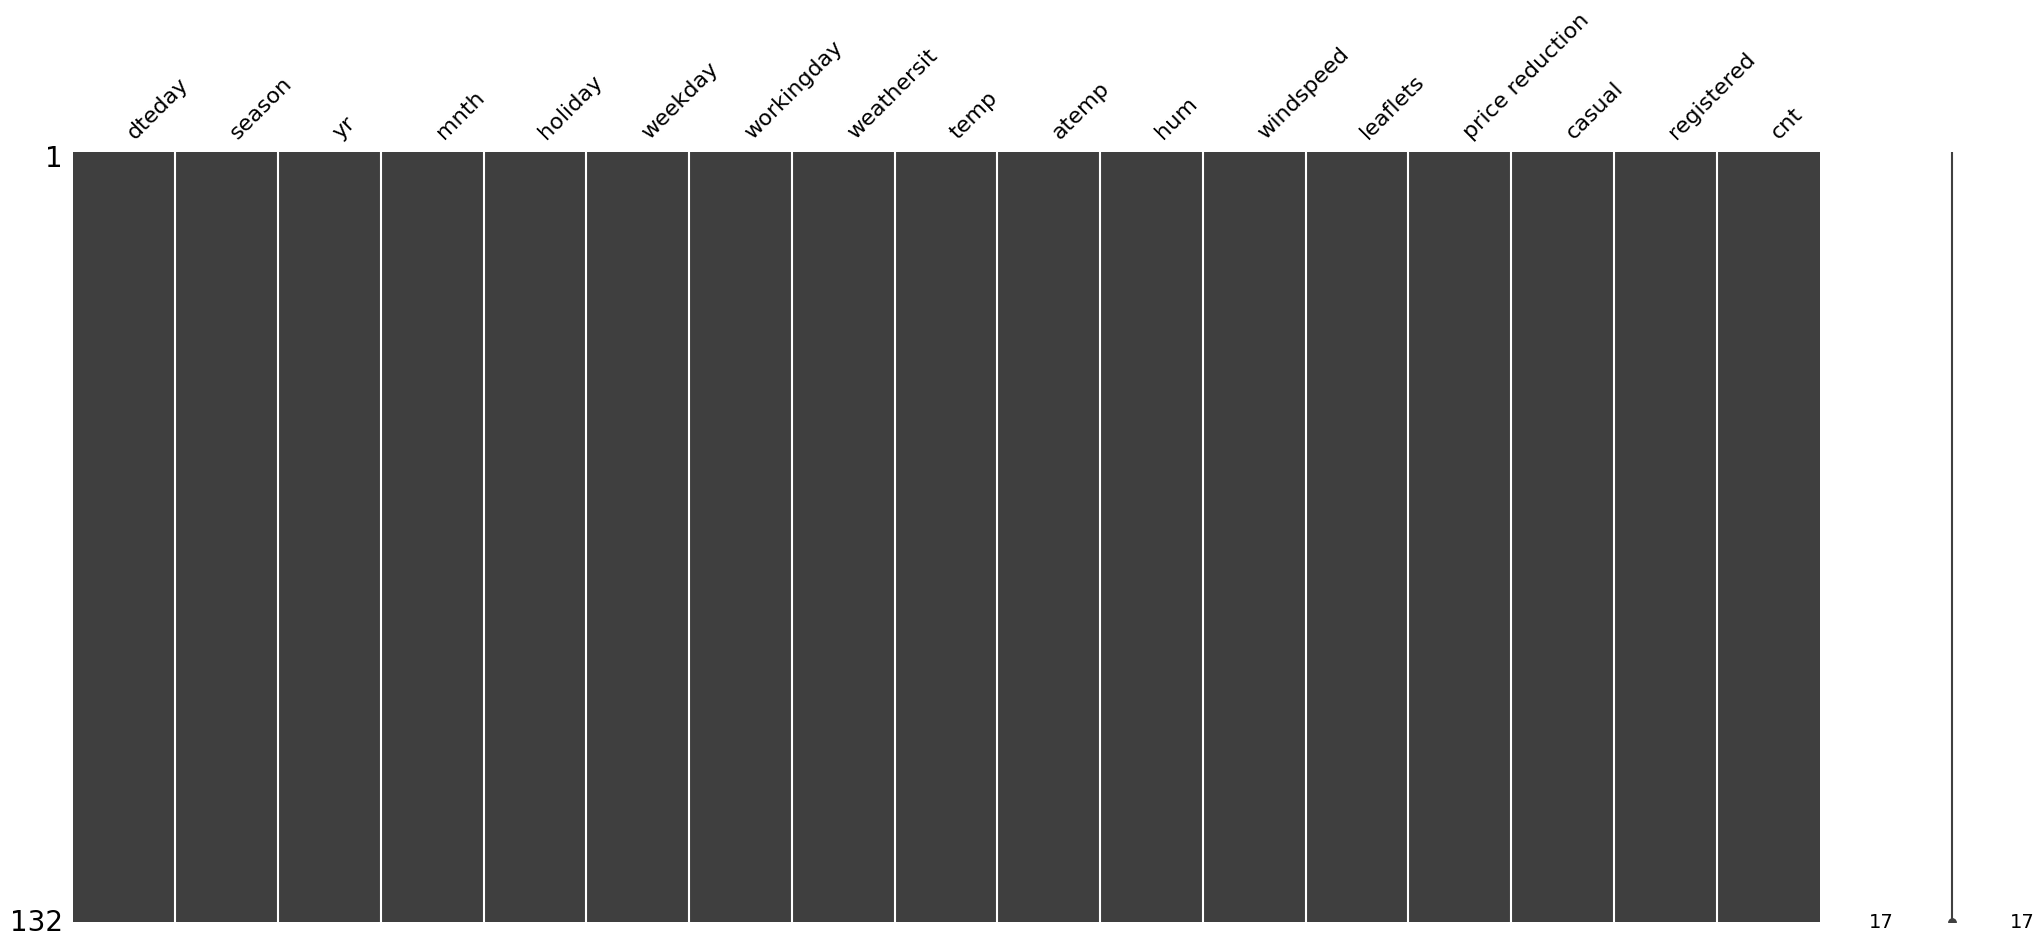

In [42]:
msno.matrix(data)

In [43]:
baseline_linreg(data)

R2 Score: -0.2
Mean Absolute Error: 1341.49

Feature Coefficients:
season 2243.68
yr 2965.89
mnth 443.53
holiday 629.21
weekday 177.09
workingday 698.39
weathersit 773.63
atemp 3212.09
hum 17.01
windspeed 520.29
leaflets 2.19
price reduction 219.23


LinearRegression()

## 6 Data Corrections

Aus der deskriptiven Statistik ist ersichltich, dass das Minimum der Variable "windspeed" bei -1 liegt. Da die Windgeschwindigkeit nicht negativ sein kann, treffen wir die Annahme, dass es sich hierbei um Fehler handeln muss. Zunächst identifizieren wir hierfür die entsprechenden Zeilen.

In [44]:
negative_rows_windspeed = data[data['windspeed'] < 0].index

negative_rows_windspeed

Index([], dtype='int64', name='instant')

In [45]:
negative_rows = data.loc[data['windspeed'] < 0]

print(negative_rows)

Empty DataFrame
Columns: [dteday, season, yr, mnth, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, leaflets, price reduction, casual, registered, cnt]
Index: []


Hier würde sich ggf. eine Regression Imputation zum Auffüllen der vier fehlenden Werte anbieten. Aus der Correlation Matrix sehen wir aber, dass `windspeed` kaum mit anderen Features korreliert. Aus diesem Grund entfernen wir die Werte.

Im Anschluss entfernen wir die entsprechenden vier Zeilen aus dem Dataframe.

In [46]:
data = data.drop(negative_rows_windspeed)

Der Wochentag `-1` ist offensichtlich ein fehlender Wert, der ebenfalls behoben werden muss.

In [47]:
def get_wday_by_date(row):
    if row["weekday"] > 0:
        return row
    weekday_shift = { # week starts on Sunday in dataset
        6: 0,
        0: 1,
        1: 2,
        2: 3,
        3: 4,
        4: 5,
        5: 6
    }
    dateformat = "%d.%m.%Y"
    row["weekday"] = weekday_shift[time.strptime(row["dteday"], dateformat).tm_wday]
    return row
data = data.apply(get_wday_by_date, axis=1)

In [48]:
baseline_linreg(data)

R2 Score: -0.2
Mean Absolute Error: 1359.2

Feature Coefficients:
season 2228.72
yr 3115.39
mnth 451.79
holiday 537.6
weekday 288.61
workingday 806.99
weathersit 862.68
atemp 3122.01
hum 14.7
windspeed 304.86
leaflets 1.74
price reduction 159.42


LinearRegression()

## 7 Outlier Detection and Handling

Es ist zu sehen, dass die Gesamtanzahl und die Zahl der nicht registrierten Nutzer einen sehr hohen Maximalwert haben. Die Gesamtzahl wird aus registrierten Nutzern und nicht registrierten Nutzern hergeleitet. Die Outlier werden dann mittels der `casual` Spalte ermittelt.

In [49]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
season,132.0,2.681818,1.114226,1.000000,2.000000,3.000000,4.000000,4.000000
yr,132.0,0.515152,0.501674,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,132.0,6.750000,3.497818,1.000000,3.750000,7.000000,10.000000,12.000000
holiday,132.0,0.022727,0.149600,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,132.0,2.840909,1.995528,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,132.0,0.704545,0.457985,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,132.0,1.371212,0.558150,1.000000,1.000000,1.000000,2.000000,3.000000
temp,132.0,19.844301,7.827241,3.895700,13.300000,19.200000,27.366675,33.933300
atemp,132.0,0.477679,0.173988,0.117930,0.325754,0.470002,0.635919,0.840896
hum,132.0,93.645418,20.970237,0.000000,80.843775,93.645418,106.546837,139.500000


Da `cnt` die Summe aus `casual` und `registered` ist, werden beim Entfernen der Outlier von `casual` auch die Outlier von `cnt` entfernt.

In [50]:
zscores = stats.zscore(data["casual"])
thresh = 3.0
outliers = data[abs(zscores) > thresh]
outliers

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,leaflets,price reduction,casual,registered,cnt
instant,,,,,,,,,,,,,,,,,
638,29.09.2012,4,1,9,0,6,0,1,21.7,0.530296,81.43755,0.227604,1001,0,26506,5966,32472


Diese Werte werden entfernt

In [51]:
data_no_out = data.drop(outliers.index, errors="ignore")

In [52]:
data_no_out.describe().T

,count,mean,std,min,25%,50%,75%,max
season,131.0,2.671756,1.112466,1.000000,2.000000,3.000000,4.000000,4.000000
yr,131.0,0.511450,0.501788,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,131.0,6.732824,3.505654,1.000000,3.500000,7.000000,10.000000,12.000000
holiday,131.0,0.022901,0.150161,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,131.0,2.816794,1.983786,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,131.0,0.709924,0.455539,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,131.0,1.374046,0.559339,1.000000,1.000000,1.000000,2.000000,3.000000
temp,131.0,19.830135,7.855589,3.895700,13.200000,19.033300,27.533350,33.933300
atemp,131.0,0.477278,0.174595,0.117930,0.325125,0.469054,0.636282,0.840896
hum,131.0,93.738608,21.023283,0.000000,80.812500,93.645418,106.843725,139.500000


In [53]:
baseline_linreg(data_no_out)

R2 Score: 0.79
Mean Absolute Error: 627.16

Feature Coefficients:
season 731.07
yr 2360.75
mnth 82.66
holiday 58.94
weekday 138.42
workingday 210.5
weathersit 466.25
atemp 4479.73
hum 4.19
windspeed 1640.48
leaflets 0.13
price reduction 238.39


LinearRegression()

## 8 Feature Transformation

### Dummies / One Hot Encoding ###

Für die Variablen `weekday` und `weathersit` erstellen wir mittels One Hot Encoding separate binäre Spalten für jede Ausprägung. Anschließend entfernen wir die ursprünglichen zwei Spalten.

In [54]:
data_d = pd.concat([data_no_out, pd.get_dummies(data_no_out["weekday"], prefix="weekday", dtype=int)], axis=1)
data_d = pd.concat([data_no_out, pd.get_dummies(data_no_out["season"], prefix="season", dtype=int)], axis=1)
data_d = pd.concat([data_d, pd.get_dummies(data_no_out["weathersit"], prefix="weathersit", dtype=int)], axis=1)
data_d.drop(columns=["weekday", "weathersit"], inplace=True)

In [55]:
data_d

,dteday,season,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,...,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3
instant,,,,,,,,,,,,,,,,,,,,,
299,26.10.2011,4,0,10,0,1,19.3667,0.472846,108.062550,0.148642,...,404,3490,3894,0,0,0,1,0,1,0
458,02.04.2012,2,1,4,0,1,17.3565,0.427513,75.652200,0.312139,...,1208,4728,5936,0,1,0,0,1,0,0
687,17.11.2012,4,1,11,0,0,13.0000,0.326383,81.812550,0.179729,...,1313,4316,5629,0,0,0,1,1,0,0
346,12.12.2011,4,0,12,0,1,9.5333,0.270196,93.645418,0.063450,...,143,3167,3310,0,0,0,1,1,0,0
291,18.10.2011,4,0,10,0,1,21.3000,0.522721,105.250050,0.110087,...,637,4111,4748,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,01.03.2012,1,1,3,0,1,19.4333,0.475371,92.312550,0.226987,...,325,4665,4990,1,0,0,0,1,0,0
547,30.06.2012,3,1,6,0,0,30.6000,0.687508,90.187500,0.161071,...,1455,4232,5687,0,0,1,0,1,0,0
271,28.09.2011,4,0,9,0,1,25.4000,0.575158,127.312500,0.148629,...,480,3427,3907,0,0,0,1,0,1,0


In [56]:
final_model = baseline_linreg(data_d)

import pickle
filename = 'models/final_model.pkl'
pickle.dump(final_model, open(filename, 'wb'))

R2 Score: 0.85
Mean Absolute Error: 551.6

Feature Coefficients:
season 449.32
yr 2191.96
mnth 21.41
holiday 122.36
workingday 358.78
atemp 4856.19
hum 7.69
windspeed 1413.91
leaflets 0.58
price reduction 339.43
season_1 453.29
season_2 563.0
season_3 215.44
season_4 105.73
weathersit_1 545.94
weathersit_2 317.91
weathersit_3 863.86


FileNotFoundError: [Errno 2] No such file or directory: 'models/final_model.pkl'

Zuletzt exportieren wir das Datenset als CSV.

In [57]:
data_d.to_csv(f"../data/prepared_{file_to_prepare}.csv", sep=";")

In [58]:
data_d.describe().T

,count,mean,std,min,25%,50%,75%,max
season,131.0,2.671756,1.112466,1.000000,2.000000,3.000000,4.000000,4.000000
yr,131.0,0.511450,0.501788,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,131.0,6.732824,3.505654,1.000000,3.500000,7.000000,10.000000,12.000000
holiday,131.0,0.022901,0.150161,0.000000,0.000000,0.000000,0.000000,1.000000
workingday,131.0,0.709924,0.455539,0.000000,0.000000,1.000000,1.000000,1.000000
temp,131.0,19.830135,7.855589,3.895700,13.200000,19.033300,27.533350,33.933300
atemp,131.0,0.477278,0.174595,0.117930,0.325125,0.469054,0.636282,0.840896
hum,131.0,93.738608,21.023283,0.000000,80.812500,93.645418,106.843725,139.500000
windspeed,131.0,0.185027,0.068570,0.042304,0.135583,0.178479,0.226681,0.385571
leaflets,131.0,747.633588,177.812529,458.000000,582.000000,742.000000,913.000000,1028.000000


In [59]:
y_pred = final_model.predict(data_d.drop(columns=["cnt", "dteday", "casual", "registered"]))

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- temp


In [ ]:
r2 = r2_score(data_d['cnt'], y_pred).round(2)
mae = mean_absolute_error(data_d['cnt'], y_pred=y_pred).round(2)

print(f'R2 Score: {r2}')
print(f'Mean Absolute Error: {mae}')
print("\nFeature Coefficients:")
for coef, feature in zip(final_model.coef_, data_d.columns):
    print(feature, abs(round(coef, 2)))